# Lab 04: Spread & Color Theory

## Objectives

- Compare **box**, **violin**, and **ridgeline** plots for distribution shape.  
- Understand **RGB, CMY, HSV/HSI** models and extract channels from images.  
- Apply **color harmony** ideas (complementary, triadic, analogous) to build palettes.  
- Use **heatmaps** effectively with custom palettes & correlation matrices.  
- Handle **outliers** via clipping, quantile normalization, hybrid transforms, and **multi‑checkpoint gradients**.

**Tools Used**

- Google Colab
- NumPy
- Pandas
- Matplotlib
- Seaborn

## Setup

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joypy

from skimage import data, transform, color, img_as_float
from palettable.colorbrewer.qualitative import Set2_8

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True

## Datasets & Tools

- **`iris`** and **`flights`** (seaborn).  
- **`astronaut`** (skimage) for RGB channels.  
- Additional: `joypy` for ridgeline plots.

In [3]:
iris = sns.load_dataset('iris')
flights = sns.load_dataset('flights')
astr = data.astronaut()
iris.head(), flights.head(), astr.shape

(   sepal_length  sepal_width  petal_length  petal_width species
 0           5.1          3.5           1.4          0.2  setosa
 1           4.9          3.0           1.4          0.2  setosa
 2           4.7          3.2           1.3          0.2  setosa
 3           4.6          3.1           1.5          0.2  setosa
 4           5.0          3.6           1.4          0.2  setosa,
    year month  passengers
 0  1949   Jan         112
 1  1949   Feb         118
 2  1949   Mar         132
 3  1949   Apr         129
 4  1949   May         121,
 (512, 512, 3))

---

## Part A — Spread Plots

### A.1 Box Plots

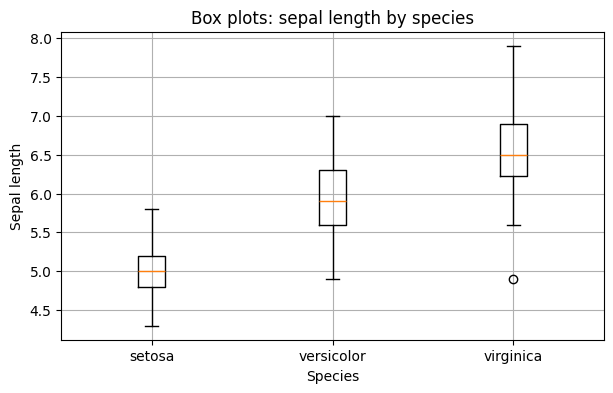

In [4]:
plt.figure()
for i, sp in enumerate(sorted(iris['species'].unique())):
    vals = iris.loc[iris['species']==sp, 'sepal_length']
    plt.boxplot(vals, positions=[i+1])
plt.xticks([1,2,3], sorted(iris['species'].unique()))
plt.xlabel('Species'); plt.ylabel('Sepal length')
plt.title('Box plots: sepal length by species')
plt.show()

### A.2 Violin Plots (approx with KDE & symmetry)

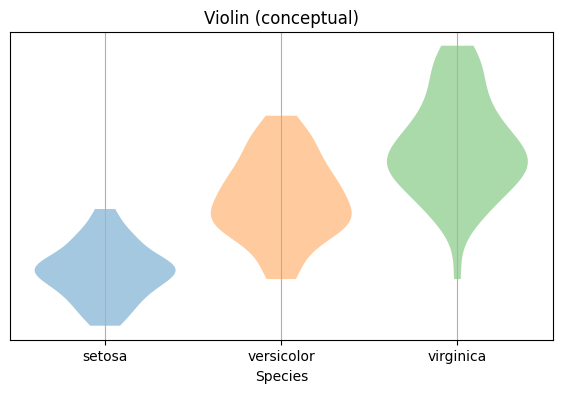

In [5]:
from scipy.stats import gaussian_kde

species = sorted(iris['species'].unique())
for i, sp in enumerate(species, start=1):
    vals = iris.loc[iris['species']==sp, 'sepal_length'].to_numpy()
    kde = gaussian_kde(vals)
    xs = np.linspace(vals.min(), vals.max(), 200)
    dens = kde(xs)
    dens = dens / dens.max() * 0.4
    plt.fill_betweenx(xs, i - dens, i + dens, alpha=0.4)

plt.yticks([])
plt.xticks(range(1,len(species)+1), species)
plt.xlabel('Species'); plt.title('Violin (conceptual)')
plt.show()

### A.3 Ridgeline Plots

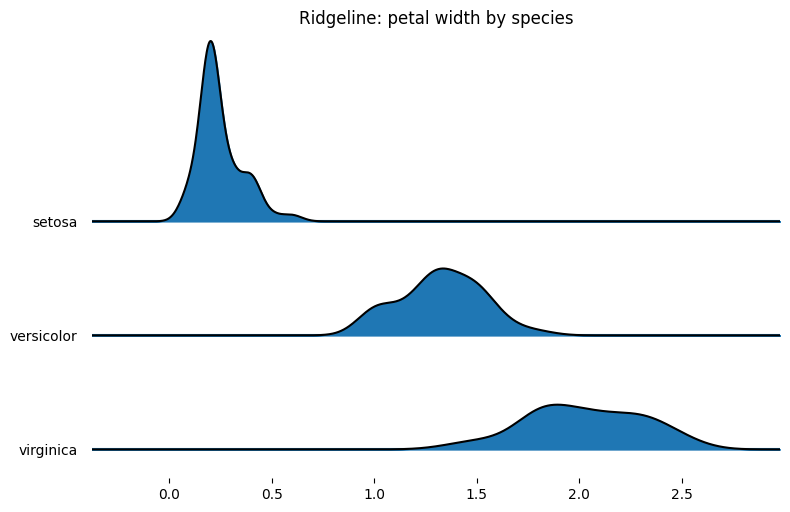

In [6]:
joypy.joyplot(
    iris, by='species', column='petal_width', figsize=(8,5),
    kind='kde', overlap=1.5
)
plt.title('Ridgeline: petal width by species')
plt.show()

#### ✅ Your Turn — Spread

1) For `iris`, compare **box vs violin** for `petal_length` across species. Which better reveals multimodality?  
2) Make a **ridgeline** for `sepal_width`. Adjust `overlap` and note the effect.

In [7]:
# TODO: Your code for A.Your Turn

---

## Part B — Color Models & Harmony

### B.1 Extract RGB & HSV Channels from an Image

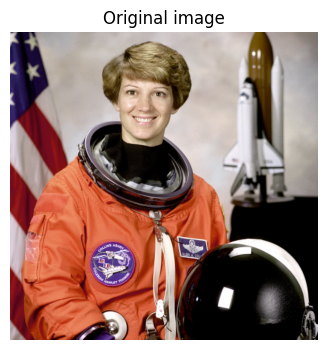

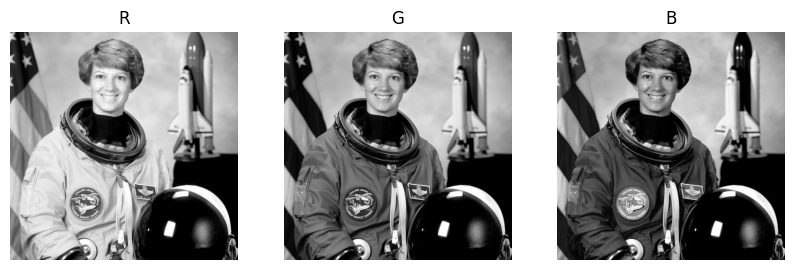

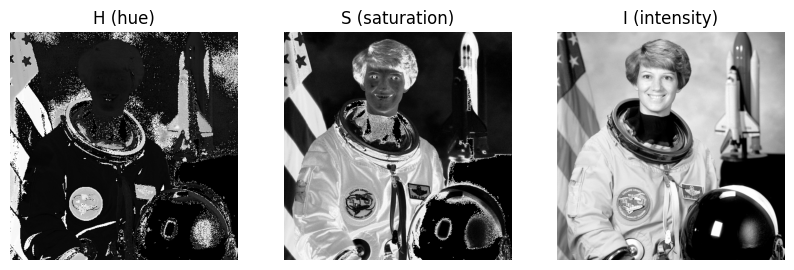

In [8]:
from skimage import data, img_as_float, color

img = img_as_float(astr)
hsi = color.rgb2hsv(img)

# Original image
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title("Original image")
plt.axis("off")
plt.show()

# RGB channels
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].imshow(img[...,0], cmap='gray'); ax[0].set_title('R'); ax[0].axis('off')
ax[1].imshow(img[...,1], cmap='gray'); ax[1].set_title('G'); ax[1].axis('off')
ax[2].imshow(img[...,2], cmap='gray'); ax[2].set_title('B'); ax[2].axis('off')
plt.show()

# HSI channels
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].imshow(hsi[...,0], cmap='gray'); ax[0].set_title('H (hue)'); ax[0].axis('off')
ax[1].imshow(hsi[...,1], cmap='gray'); ax[1].set_title('S (saturation)'); ax[1].axis('off')
ax[2].imshow(hsi[...,2], cmap='gray'); ax[2].set_title('I (intensity)'); ax[2].axis('off')
plt.show()

### B.2 Harmony: Complementary, Triadic, Analogous (Hue arithmetic)

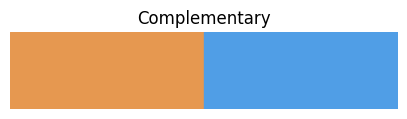

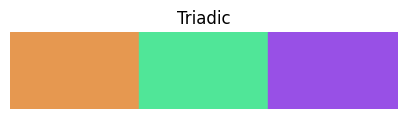

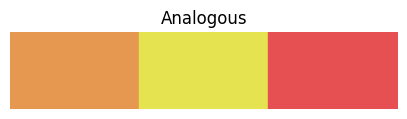

In [9]:
def hue_wrap(h):
    h = np.mod(h, 1.0)
    return h

def palette_from_hue(h, mode='complementary'):
    if mode == 'complementary':
        hs = [h, hue_wrap(h+0.5)]
    elif mode == 'triadic':
        hs = [h, hue_wrap(h+1/3), hue_wrap(h+2/3)]
    elif mode == 'analogous':
        hs = [h, hue_wrap(h+1/12), hue_wrap(h-1/12)]
    else:
        hs = [h]
    cols = [color.hsv2rgb([hh, 0.65, 0.9]) for hh in hs]
    return np.array(cols)

def show_palette(cols, title):
    fig, ax = plt.subplots(figsize=(5,1))
    for i, c in enumerate(cols):
        ax.add_patch(plt.Rectangle((i,0), 1,1, color=c))
    ax.set_xlim(0, len(cols)); ax.set_ylim(0,1); ax.axis('off')
    plt.title(title); plt.show()

cols = palette_from_hue(0.08, 'complementary'); show_palette(cols, 'Complementary')
cols = palette_from_hue(0.08, 'triadic');       show_palette(cols, 'Triadic')
cols = palette_from_hue(0.08, 'analogous');     show_palette(cols, 'Analogous')

#### ✅ Your Turn — Color Models

1) Pick any base hue and generate **complementary**, **triadic**, and **analogous** palettes.  
2) Recolor one of your plots using the generated palette and comment on readability.

In [10]:
# TODO: Your code for B.Your Turn

---

## Part C — Heatmaps & Palettes

### C.1 Seaborn Heatmap with Custom Palette

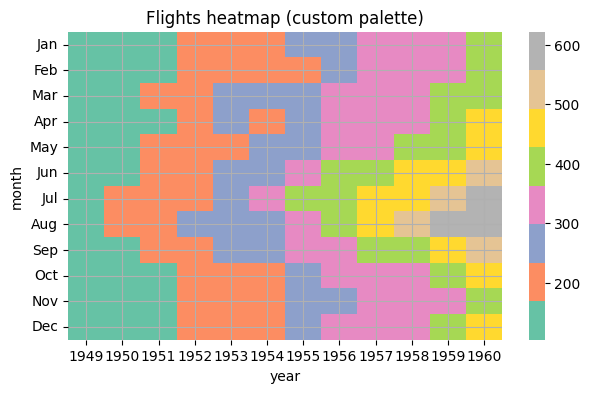

In [11]:
pvt = flights.pivot(index='month', columns='year', values='passengers')

palette = Set2_8.mpl_colors
from matplotlib.colors import ListedColormap
cmap = ListedColormap(palette)

sns.heatmap(pvt, cmap=cmap)
plt.title('Flights heatmap (custom palette)')
plt.show()

### C.2 Correlation Matrix with Divergent Palette

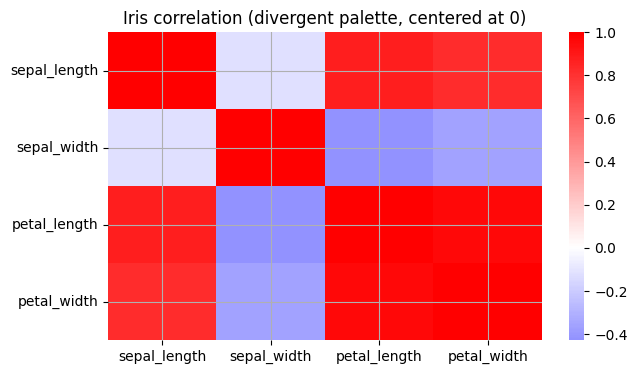

In [12]:
corr = iris.drop(columns=['species']).corr()

from matplotlib.colors import LinearSegmentedColormap
cmap_div = LinearSegmentedColormap.from_list('bwrd', [(0,'blue'),(0.5,'white'),(1,'red')])

sns.heatmap(corr, cmap=cmap_div, center=0, annot=False)
plt.title('Iris correlation (divergent palette, centered at 0)')
plt.show()

### C.3 Effect of Different Palettes on the Same Heatmap

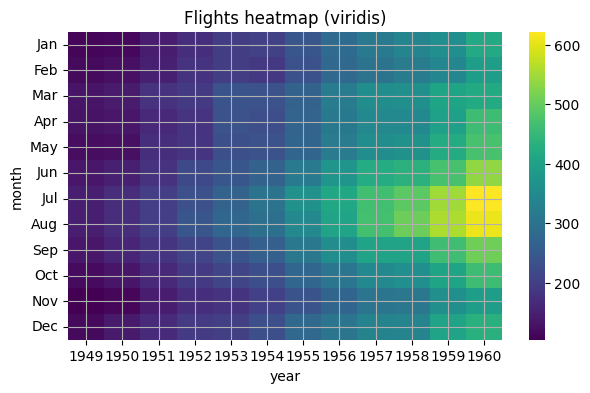

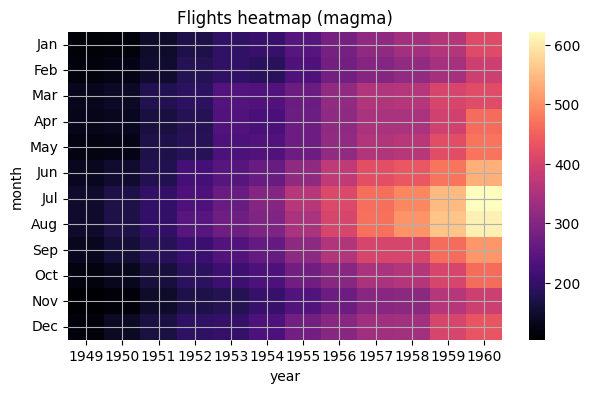

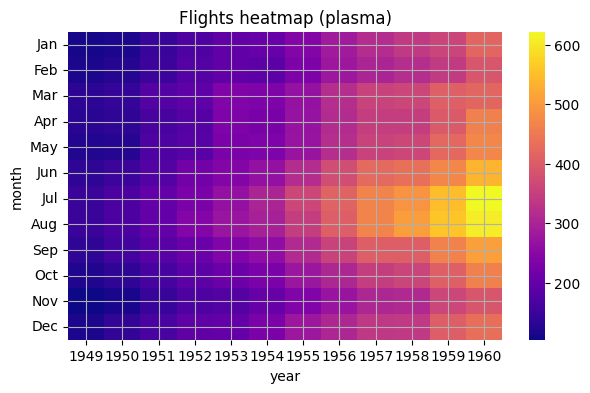

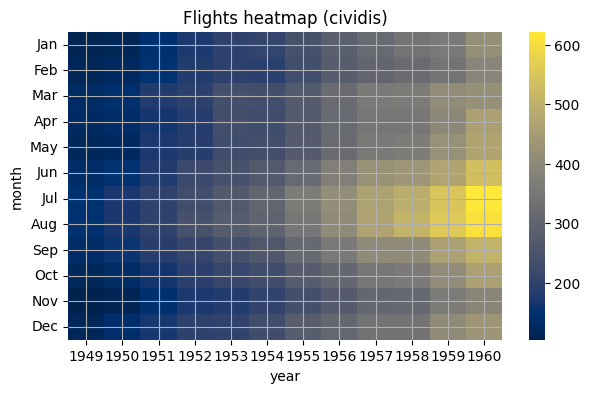

In [13]:
for cmap_name in ['viridis', 'magma', 'plasma', 'cividis']:
    sns.heatmap(pvt, cmap=cmap_name)
    plt.title(f'Flights heatmap ({cmap_name})')
    plt.show()

### C.4 Outliers in Heatmaps & Opacity

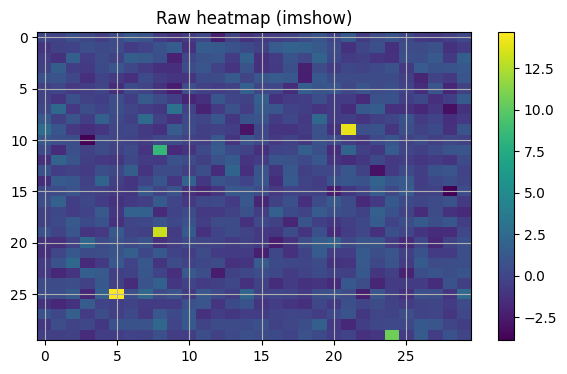

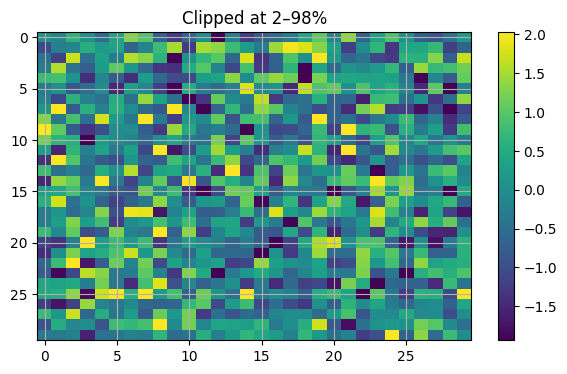

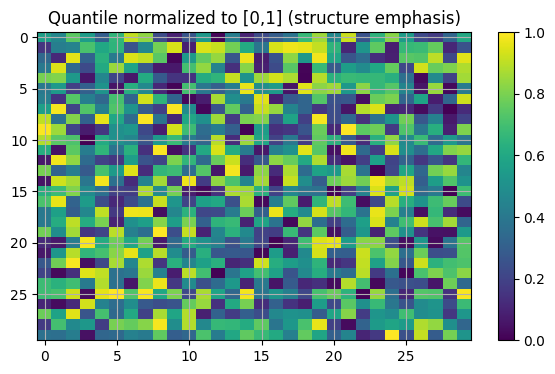

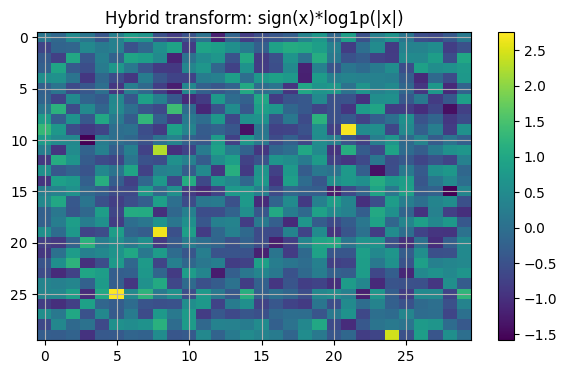

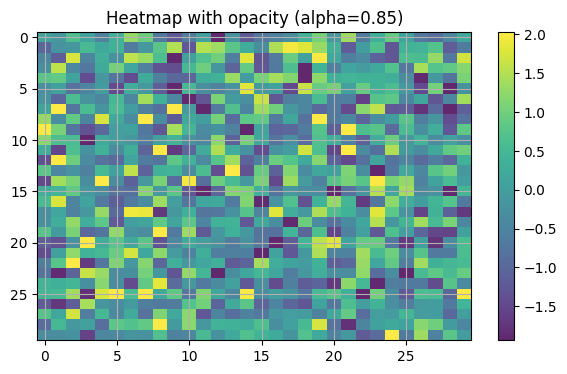

In [14]:
rng = np.random.default_rng(0)
M = rng.normal(0, 1, size=(30, 30))
M[rng.integers(0,30,5), rng.integers(0,30,5)] = rng.normal(12, 2, size=5)  # a few big outliers

plt.imshow(M, aspect='auto')
plt.title('Raw heatmap (imshow)')
plt.colorbar(); plt.show()

# Clip extremes
M_clip = np.clip(M, np.quantile(M, 0.02), np.quantile(M, 0.98))
plt.imshow(M_clip, aspect='auto')
plt.title('Clipped at 2–98%')
plt.colorbar(); plt.show()

# Quantile normalization (rank map to [0,1])
flat = M.flatten()
ranks = flat.argsort().argsort() / (flat.size - 1)
M_q = ranks.reshape(M.shape)
plt.imshow(M_q, aspect='auto')
plt.title('Quantile normalized to [0,1] (structure emphasis)')
plt.colorbar(); plt.show()

# Hybrid transform (preserve sign, compress tails)
def hybrid(x):
    return np.sign(x) * np.log1p(np.abs(x))
plt.imshow(hybrid(M), aspect='auto')
plt.title('Hybrid transform: sign(x)*log1p(|x|)')
plt.colorbar(); plt.show()

# Opacity: layer a semi-transparent heatmap over a grid
fig, ax = plt.subplots()
im = ax.imshow(M_clip, aspect='auto', alpha=0.85)
plt.colorbar(im, ax=ax)
ax.set_title('Heatmap with opacity (alpha=0.85)'); plt.show()

### C.5 Multi‑Checkpoint Gradients (Piecewise Colormap)

**Idea:** Anchor color transitions at specific **quantiles** so mid‑range and extremes both get contrast.

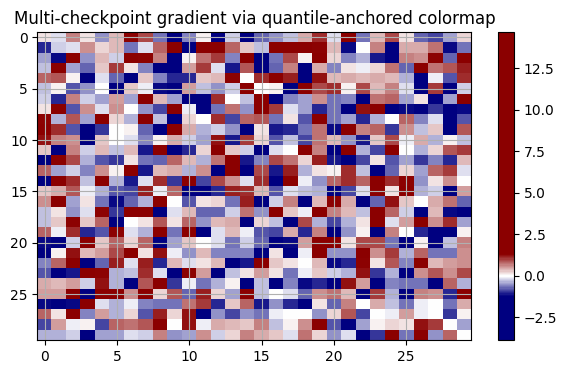

In [15]:
from matplotlib.colors import LinearSegmentedColormap

def quantile_colormap(X, qs=(0.05, 0.5, 0.95), colors=('navy','white','darkred')):
    q_vals = np.quantile(X, qs)
    vmin, vmax = X.min(), X.max()
    stops = [(q - vmin)/(vmax - vmin) for q in [vmin, *q_vals, vmax]]
    cols = [colors[0], colors[0], colors[1], colors[2], colors[2]]
    cdict = list(zip(stops, cols))
    dedup = []
    for s, c in cdict:
        if not dedup or abs(s - dedup[-1][0]) > 1e-6:
            dedup.append((s, c))
    return LinearSegmentedColormap.from_list('quantile_piecewise', dedup)

cmap_q = quantile_colormap(M, qs=(0.1, 0.5, 0.9), colors=('navy','white','darkred'))
plt.imshow(M, cmap=cmap_q, aspect='auto')
plt.title('Multi‑checkpoint gradient via quantile‑anchored colormap')
plt.colorbar(); plt.show()

#### ✅ Your Turn — Heatmaps & Color

1) Build a **correlation heatmap** for `tips` numeric columns with a **divergent** palette centered at 0.  
2) Try **clipping** vs **hybrid transform** on a matrix with injected outliers; compare interpretability.  
3) Design a **custom quantile‑anchored colormap** with at least **4 checkpoints** and apply it.

In [16]:
# TODO: Your code for C.Your Turn

---